<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b>
    Before proceeding, install or update your
    <b><a class="divlink" href="https://astroconda.readthedocs.io">
    AstroConda
    </a></b>
     distribution. The code cells below may not work properly with older versions of AstroConda.
</div>

# ACS Linearity with Saturated Stars

## Introduction

***

The ACS/WFC CCD becomes saturated around 80000 counts. When this occurs, excess charge from the source spills out lengthwise along the columns of the CCD. This can lead to issues with photometry when using very bright stars, since a significant portion of the star's flux may fall outside of a reasonable extraction radius.

However, accurate relative photometry can be obtained as long as a large enough aperture is selected to contain the spilled flux (ACS ISR 2004-01). While one could simply use a larger circular aperture, that may introduce error when working with a crowded field (as bright stars often are).

Here we present a method to identify and perform photometry on saturated sources by defining a custom aperture that is a combination of a standard 0.5" arcsecond circular aperture and the pixels affected by saturation trails.

### This tutorial will show you how to...

#### [Prepare Images](#_prep) 

* Apply Pixel Area Map
* Separate by long and short exposure
* Make sure you have images of the same field

#### [Identify Saturated Stars](#_identify)

* Identify the saturated pixels using the data quality (DQ) array
* Determine whether or not the saturation trails extend significantly away from the target

#### [Bleed the Saturation Mask](#_bleed)

* Construct a convolution kernel
* Bleed the saturation mask with the convolution kernel

#### [Define a Custom Aperture](#_define)

* Isolate central clump from your saturation mask
* Obtain circular aperture as a boolean mask
* Combine circular aperture with saturation mask

#### [Photometry with a Custom Aperture](#_phot)

* Extract counts with the custom aperture
* Estimate background to be subtracted

## Imports

***

Here we list the Python packages used in this notebook. Links to the documentation for each module is provided for convenience.

| Package Name     | module           | docs          | used for    |
|------------------|:-----------------|:-------------:|:------------|
| `os`             | `system`           | <a class="divlink" href="https://docs.python.org/2/library/os.html#os.system">link</a>|command line input|
|`glob`            | `glob`             | <a class="divlink" href="https://docs.python.org/2/library/glob.html#glob.glob">link</a>| search for files based on Unix shell rules |
|`numpy`           | `_s`               | <a class="divlink" href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.s_.html">link</a>| construct array slice object |
|`matplotlib`      |`pyplot`    | <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.colors.LogNorm.html#matplotlib.colors.LogNorm">link</a>| plotting |
|`astroquery.mast` |`Observations`      | <a class="divlink" href="https://astroquery.readthedocs.io/en/latest/mast/mast.html">link</a>| download data from MAST |
|`astropy.io`      | `fits`             | <a class="divlink" href="http://docs.astropy.org/en/stable/io/fits/">link</a>| access and update fits files |
|`astropy.stats`   |`sigma_clip`| <a class="divlink" href="http://docs.astropy.org/en/stable/api/astropy.stats.sigma_clip.html">link</a>| sigma clipping image for background estimation |
|`scipy.signal`    |`convolve2d`| <a class="divlink" href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html">link</a>| convolve saturation mask with kernel |
|`stsci.skypac`    |`pamutils`| <a class="divlink" href="https://stsci-skypac.readthedocs.io/en/stable/_modules/stsci/skypac/pamutils.html">link</a>|obtain pixel area maps (PAM) |
|`photutils`       |`CircularAperture`| <a class="divlink" href="https://photutils.readthedocs.io/en/stable/api/photutils.CircularAperture.html">link</a>| aperture object for photometry |
|`matplotlib.patches`|`Circle`| <a class="divlink" href="https://matplotlib.org/api/_as_gen/matplotlib.patches.Circle.html">link</a>| draw circle on a plot |

In [1]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

from astroquery.mast import Observations

from astropy.io import fits
from astropy.stats import sigma_clip

from scipy.signal import convolve2d
from stsci.skypac import pamutils

from photutils import CircularAperture
from matplotlib.patches import Circle
from p_module import plot

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


Setting environment variables for later use with the Calibration Reference Data System (CRDS).

In [2]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['jref'] = './crds_cache/references/hst/acs/'

## Download the Data

***

Here we download all of the data required for this notebook. This is an important step! Some of the image processing steps require all relevant files to be in the working directory. We recommend working with a brand new directory for every new set of data.

#### [GO Proposal 14949](https://stdatu.stsci.edu/proposal_search.php?mission=hst&id=14949): "ACS External CTE Monitor"

Using the python package `astroquery`, we can download files from the [MAST](http://archive.stsci.edu) archive.

In [3]:
obs_table = Observations.query_criteria(proposal_id=14949, filters='F606W')

In [4]:
dl_table = Observations.download_products(obs_table['obsid'],
                                          productSubGroupDescription=['FLC'],
                                          mrp_only=False)

INFO: Found cached file ./mastDownload/HST/jdg303d5q/jdg303d5q_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg303d7q/jdg303d7q_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg302clq/jdg302clq_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg302cnq/jdg302cnq_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg301c4q/jdg301c4q_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg301c6q/jdg301c6q_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg303d9q/jdg303d9q_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/jdg303dbq/jdg303dbq_flc.fits with expected size 167964480. [astroquery.query]
INFO: Found cached file ./mastDo

### File Information

For more information, refer to Section <a class="divlink" href="http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_Ch23.html">Section 2.2</a> of the ACS Data Handbook.

#### Raw Files

A standard raw image file from a subarray has the same structure as you'd expect from full frame observation from ACS/WCS.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| SCI (Image)      | (ImageHDU)   | Raw image data.                                        |
|<b>2</b>| ERR (Error)      | (ImageHDU)   | Error array.                                           |
|<b>3</b>| DQ (Data Quality)| (ImageHDU)   | Data quality array.                                    |

#### SPT Files

SPT files contain telemetry and engineering data from the telescope.

| Ext    | Name             | Type         | Contains                                               |
|--------|------------------|--------------|:-------------------------------------------------------|
|<b>0</b>| PRIMARY          | (PrimaryHDU) | Meta-data related to the entire file.                  |
|<b>1</b>| UDL (Image)      | (ImageHDU)   | Raw image data.                                        |

In [5]:
fname_short = 'mastDownload/HST/jdg302ctq/jdg302ctq_flc.fits'
fname_long = 'mastDownload/HST/jdg301c4q/jdg301c4q_flc.fits'

## Prepare Images
***

* Apply Pixel Area Map
* Separate by long and short exposure
* Make sure you have images of the same field

In [6]:
fitsfile = fname_short

dq_short = fits.getdata(fitsfile, ext=3)==256
raw_short = fits.getdata(fitsfile)

pname = os.path.basename(fitsfile).split('.')[0] + '_pam.fits'
pamutils.pam_from_file(fitsfile, ext=1, output_pam=pname)

pam_short = fits.getdata(pname)

img_short = raw_short * pam_short

In [7]:
fitsfile = fname_long

dq_long = fits.getdata(fitsfile, ext=3)==256
raw_long = fits.getdata(fitsfile)

pname = os.path.basename(fitsfile).split('.')[0] + '_pam.fits'
pamutils.pam_from_file(fitsfile, ext=1, output_pam=pname)

pam_long = fits.getdata(pname)

img_long = raw_long * pam_long

## Identify Saturated Stars
***

Here we have the local coordinates of three stars in our field. We also specify the pixel scale of WCS to help us with determining sizes for our apertures.

In [8]:
img_coord = [(1711, 225), (1205, 238), (3159, 312)]

pix_per_arcsec = 20

We will make cutouts around each souce with a radius of 100 pixels. This size cutout is typically big enough to contain saturation trails from the brightest stars. We will also assume that our extraction aperture has a radius of 0.5 arcseconds.

In [9]:
cutout_radius = 100
aperture_radius = 0.5 * pix_per_arcsec

Let's take a look at the first star in our list. We first can make a slice object with numpy to help make cutouts around our source.

In [10]:
x, y = img_coord[0]

starty, endy = (y - cutout_radius), (y + cutout_radius)
startx, endx = (x - cutout_radius), (x + cutout_radius)

cutter = np.s_[starty:endy, startx:endx]

Now we can take a cutout of our image around the source.

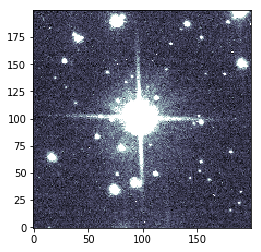

In [11]:
plot.ds9_imitate(plt, img_short[cutter])

We can visually confirm that this source is affected by saturation trails in the short exposure. What about the long exposure image?

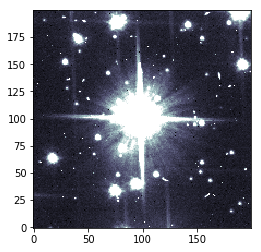

In [12]:
plot.ds9_imitate(plt, img_long[cutter])

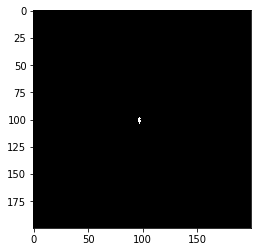

In [13]:
plt.imshow(dq_short[cutter], cmap='bone')

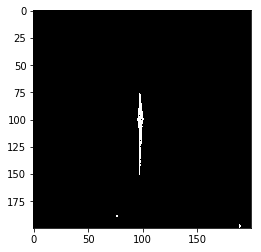

In [14]:
plt.imshow(dq_long[cutter], cmap='bone')

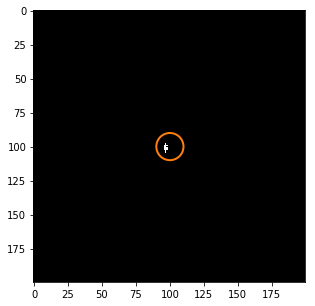

In [15]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)

circ_patch = Circle((cutout_radius, cutout_radius),
                    radius=aperture_radius,
                    color='C1',
                    linewidth=2,
                    fill=False)
ax.imshow(dq_short[cutter], cmap='bone')
ax.add_patch(circ_patch)

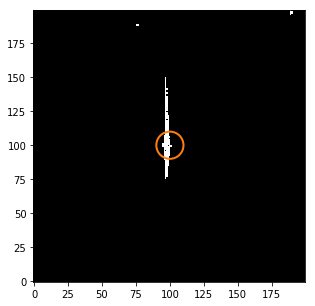

In [17]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)

circ_patch = Circle((cutout_radius, cutout_radius),
                    radius=aperture_radius,
                    color='C1',
                    linewidth=2,
                    fill=False)
ax.imshow(dq_long[cutter], cmap='bone', origin=1)
ax.add_patch(circ_patch)

Since the saturated pixels appear to extend past our extraction radius, we can use a different method to improve photometry.

## Bleed the Saturation Mask

First we need to define a kernel. We can do this by hand. Since pixels affected by saturation will spill charge along columns, all we need is to convolve our image with a column kernel.

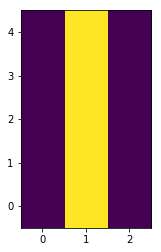

In [18]:
bleed_kernel = np.array([[0,1,0],
                         [0,1,0],
                         [0,1,0],
                         [0,1,0],
                         [0,1,0]])

plt.imshow(bleed_kernel, origin=1)

In [19]:
from scipy.signal import convolve2d

# Here, mode='same' ensures that the returned array is the same shape as the input array
conv_sat = convolve2d(dq_long[cutter], bleed_kernel, mode='same')
sat_aperture = np.array([x > 0 for x in conv_sat]).astype(bool)

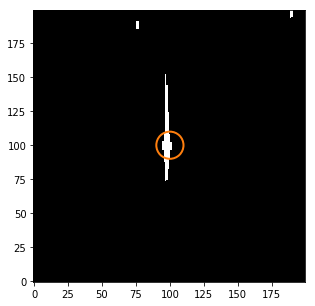

In [20]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111)

circ_patch = Circle((cutout_radius, cutout_radius),
                    radius=aperture_radius,
                    color='C1',
                    linewidth=2,
                    fill=False)
ax.imshow(sat_aperture, cmap='bone', origin=1)
ax.add_patch(circ_patch)

## Define a Custom Aperture

Now we want to create a new aperture which includes the pixels with the spilled charge. If we want to use the saturation mask we just created, we need to isolate only the clump associated with our star.

Here, we give you a function which will return a mask with only the central clump.

In [21]:
# Isolate associated clump from saturation mask

def find_central_clump(boolean_mask):
    
    from scipy import ndimage

    central_index = tuple((np.array(np.shape(boolean_mask))/2).astype(int))

    label, num_label = ndimage.label(boolean_mask == True)
    size = np.bincount(label.ravel())
    
    clump_labels = range(size[1:].shape[0])
    
    is_central_clump = False
    
    for cl in clump_labels:
        
        clump_mask = label == (cl + 1)
        idxs = [tuple(i) for i in np.argwhere(clump_mask)]
        is_central_clump = central_index in idxs

        if is_central_clump:
            
            return clump_mask
        
        else: continue
        
    if not is_central_clump:
        
        return 0

Now we can apply this function to our mask

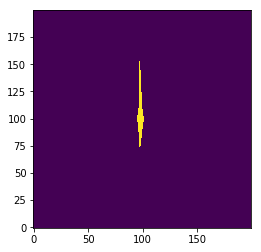

In [22]:
central_clump = find_central_clump(sat_aperture)

plt.imshow(central_clump, origin=1)

Now we can use the circular aperture in the package `photutils`. To combine it with our mask, we need the circular aperture in mask form. Luckily, this is a built-in feature of aperture objects!

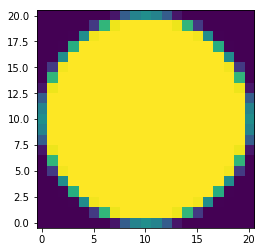

In [24]:
aperture = CircularAperture((cutout_radius, cutout_radius), aperture_radius)
aperture_mask = np.array(aperture.to_mask()[0])

plt.imshow(aperture_mask, origin=1)

To match the size of our cutout, we can create a new array with our circular aperture at the center

In [25]:
np.shape(sat_aperture)

(200, 200)

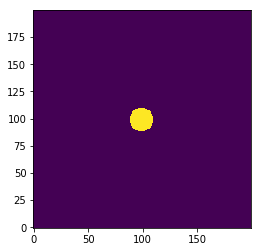

In [26]:
circular_mask = np.zeros(np.shape(sat_aperture))

aperture_dim = np.shape(aperture_mask)
cutout_dim = np.shape(circular_mask)

insert_start = int((cutout_dim[0] - aperture_dim[0]) / 2)
insert_end = int(insert_start + aperture_dim[0])

circular_mask[insert_start:insert_end, insert_start:insert_end] = aperture_mask
    
circular_mask = circular_mask.astype(bool)
plt.imshow(circular_mask, origin=1)

Now we want to combine both of our masks to form one aperture.

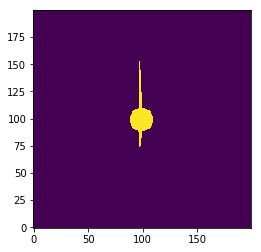

In [27]:
combined_aperture = np.logical_or(central_clump, circular_mask)
plt.imshow(combined_aperture, origin=1)

## Photometry with a Custom Aperture

To get the local background for each source, we will use sigma-clipped cutouts of the image to obtain the median background value. We will then estimate the background in our new aperture by multiplying the median by the area covered by the aperture.

In [30]:
img_cutout = img_long[cutter]
flux_sum = np.sum(img_cutout[combined_aperture])

bkg_data = sigma_clip(img_cutout, sigma=3, iters=5)

new_aperture_area = np.sum(combined_aperture)
bkg_sum = np.median(bkg_data) * new_aperture_area

final_sum = flux_sum - bkg_sum

/Users/molaes/Software/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [31]:
def make_cutter(x, y, cutout_radius=100):

    starty, endy = (y - cutout_radius), (y + cutout_radius)
    startx, endx = (x - cutout_radius), (x + cutout_radius)
    
    return np.s_[starty:endy, startx:endx]

fitsfile = fname_long

pname = os.path.basename(fitsfile).split('.')[0] + '_pam.fits'
pamutils.pam_from_file(fitsfile, ext=1, output_pam=pname)

raw_array = fits.getdata(fitsfile)
pam_array = fits.getdata(pname)
img_array = raw_array * pam_array

sat_array = fits.getdata(fitsfile, ext=3)==256

cutter = make_cutter(x, y)
img_cutout = img_array[cutter]
sat_cutout = sat_array[cutter]

sat_mask = find_central_clump(sat_cutout)
cir_mask = circular_mask

custom_aperture = np.logical_or(sat_mask, cir_mask)
flux_sum = np.sum(img_cutout[combined_aperture])
bkg_data = sigma_clip(img_cutout, sigma=3, iters=5)

new_aperture_area = np.sum(combined_aperture)
bkg_sum = np.median(bkg_data) * new_aperture_area

final_sum = flux_sum - bkg_sum

/Users/molaes/Software/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### References

***

http://iopscience.iop.org/article/10.1086/444553

http://documents.stsci.edu/hst/acs/documents/handbooks/DataHandbookv3/acs_Ch57.html

